In [1]:
import torch
import numpy as np
import os
import random

SEED = 42

# Python
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# cuDNN settings
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    """Ensure each DataLoader worker has a deterministic seed."""
    worker_seed = SEED
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [2]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd

In [3]:
# get data
import wrds
db = wrds.Connection()
crsp_df = db.raw_sql("""
    select
      a.permno, a.date,
      n.shrcd, n.exchcd,
      a.prc, a.vol, a.shrout, a.ret,
      b.dlstdt, b.dlret
    from crsp.msf a
    left join crsp.msedelist b
      on a.permno = b.permno
     and b.dlstdt >= date_trunc('month', a.date)
     and b.dlstdt <  date_trunc('month', a.date) + interval '1 month'
    left join crsp.msenames n
      on a.permno = n.permno
     and a.date between n.namedt and n.nameendt
    where a.date >= '2005-01-01'
      and n.shrcd in (10, 11) and n.exchcd in (1, 2, 3)
""")

# Normalize column names to uppercase
crsp_df.columns = [c.upper() for c in crsp_df.columns]

# Convert date column to datetime
crsp_df["DATE"] = pd.to_datetime(crsp_df["DATE"])

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [4]:
# 2) CRSP daily high/low (cs_daily)
cs_daily = db.raw_sql("""
    select
      a.permno,
      a.date,
      a.askhi as hi,   -- daily high price (highest quoted ask)
      a.bidlo as lo    -- daily low price (lowest quoted bid)
    from crsp.dsf a
    join crsp.dsenames n
      on a.permno = n.permno
     and a.date between n.namedt and n.nameendt
    where a.date >= '2005-01-01'
      and n.shrcd in (10, 11)
      and n.exchcd in (1, 2, 3)
""")

cs_daily.columns = [c.upper() for c in cs_daily.columns]
cs_daily["DATE"] = pd.to_datetime(cs_daily["DATE"])

In [5]:
#  Construct a "VIX proxy" using CRSP market index volatility
start_date = crsp_df["DATE"].min() - pd.DateOffset(months=6)
end_date   = crsp_df["DATE"].max() + pd.DateOffset(months=1)

mkt_d = db.raw_sql(f"""
    select date, vwretd
    from crsp.msi
    where date >= '{start_date.date()}'
      and date <= '{end_date.date()}'
""")

mkt_d["DATE"] = pd.to_datetime(mkt_d["date"])
mkt_d = mkt_d.sort_values("DATE")
mkt_d["MKT_RET"] = mkt_d["vwretd"].astype(float)

# 63 trading days ≈ 3 months
# Rolling realized volatility (annualized) as a VIX proxy
mkt_d["VIX_PROXY_D"] = (
    mkt_d["MKT_RET"]
    .rolling(window=63, min_periods=20)
    .std() * np.sqrt(252)   # annualized volatility
)

# Align daily VIX proxy to month-end and take monthly average
mkt_d["DATE_M"] = mkt_d["DATE"] + MonthEnd(0)

vix_m = (
    mkt_d.groupby("DATE_M")["VIX_PROXY_D"]
         .mean()
         .reset_index()
         .rename(columns={"DATE_M": "DATE", "VIX_PROXY_D": "VIX"})
)

In [6]:
#  === Rate proxy (monthly short-term interest rate using Fama-French RF) ===
ff_m = db.raw_sql(f"""
    select date, rf
    from ff.factors_monthly
    where date >= '{start_date.date()}'
      and date <= '{end_date.date()}'
""")

ff_m["DATE"] = pd.to_datetime(ff_m["date"]) + MonthEnd(0)
ff_m = ff_m.sort_values("DATE")

# RF is in percentage format; convert to decimal to represent short-term yield
ff_m["Y_SHORT"] = ff_m["rf"].astype(float) / 100.0

rate_m = ff_m[["DATE", "Y_SHORT"]].copy()

In [7]:
df = crsp_df.copy()

In [8]:
df.describe()

,PERMNO,DATE,SHRCD,EXCHCD,PRC,VOL,SHROUT,RET,DLRET
count,961946.0,961946,961946.0,961946.0,961891.0,961939.0,961946.0,956994.0,722.0
mean,59526.773413,2014-09-29 02:50:26.400235008,11.0,2.270873,94.454957,261271.765752,122474.575617,0.007337,-0.021192
min,10001.0,2005-01-31 00:00:00,11.0,1.0,-1053.75,0.0,9.0,-0.99569,-0.999444
25%,20454.0,2009-05-29 00:00:00,11.0,1.0,5.35,10140.0,15556.0,-0.067568,-0.00307
50%,77447.0,2014-07-31 00:00:00,11.0,3.0,15.8,50081.0,35815.0,0.001361,0.000822
75%,87612.0,2020-01-31 00:00:00,11.0,3.0,36.11,179313.5,85055.0,0.067568,0.013143
max,93436.0,2024-12-31 00:00:00,11.0,3.0,724040.0,201242689.0,29206400.0,26.583828,3.688701
std,31818.208102,NaN,0.0,0.929564,4583.833081,1212270.778438,465952.450392,0.195411,0.22293


In [9]:
def make_features_monthly(df: pd.DataFrame):
    # Align data to month-end and sort
    df = df.copy()
    df["DATE"] = df["DATE"] + MonthEnd(0)  
    df = df.sort_values(["PERMNO", "DATE"]).reset_index(drop=True)

    # Basic transformations
    df["PRC"] = df["PRC"].abs()
    df["LOG_PRC"] = np.log(df["PRC"].clip(1e-6))
    df["LOG_VOL"] = np.log(df["VOL"].clip(1.0))

    # Construct true monthly return accounting for delisting returns
    df["RET"] = (1+df["RET"].fillna(0.0)) * (1+df["DLRET"].fillna(0.0)) - 1.0
    df["MKT_CAP"] = df["PRC"] * df["SHROUT"] * 1e3  # Market capitalization: price × shares outstanding (in thousands)

    # Compute features within each stock
    def by_perm(g: pd.DataFrame) -> pd.DataFrame:
        g = g.sort_values("DATE")
        out = pd.DataFrame(index=g.index)

        # Raw monthly return
        out["RET"] = g["RET"]

        # (1) 3-month and 12-month momentum (multiplicative form)
        ret1 = (1.0 + g["RET"].fillna(0.0))
        out["MOM_3M"] = ret1.rolling(3, min_periods=3).apply(np.prod, raw=True) - 1.0
        out["MOM_12M"] = ret1.rolling(12, min_periods=12).apply(np.prod, raw=True) - 1.0

        # (2) 6-month volatility, annualized using sqrt(12)
        out["VOL_6M"] = g["RET"].rolling(6, min_periods=4).std() * np.sqrt(12.0)

        # (3) Monthly changes in log price and log volume
        out["DLOG_P"] = g["LOG_PRC"].diff()
        out["DLOG_V"] = g["LOG_VOL"].diff()

        # (4) Within-stock rolling standardization: 6-month window, min 6 months
        for col in ["RET", "MOM_3M", "MOM_12M", "VOL_6M", "DLOG_P", "DLOG_V"]:
            m = out[col].rolling(6, min_periods=6).mean()
            s = out[col].rolling(6, min_periods=6).std().replace(0, np.nan)
            out[col + "_Z"] = (out[col] - m) / s

        return out

    # Reset index to avoid misalignment during concatenation
    feats = (
        df.groupby("PERMNO", group_keys=False, sort=False)
          .apply(by_perm, include_groups=False)
          .reset_index(drop=True)
    )

    # Target: next-month forward return (1-month ahead)
    def fwd_1m(s: pd.Series) -> pd.Series:
        # Shift returns by 1 month and compute next-month growth
        s1 = (1.0 + s.fillna(0.0)).shift(-1)
        prod1 = s1.rolling(1, min_periods=1).apply(np.prod, raw=True)
        return prod1 - 1.0

    df["Y_FWD_1M"] = df.groupby("PERMNO")["RET"].transform(fwd_1m)
    # Cap forward returns to avoid extreme outliers
    df["Y_FWD_1M"] = df["Y_FWD_1M"].clip(lower=-0.5, upper=0.5)

    # Re-align base columns with feature matrix
    df_base = df[["DATE","PERMNO","RET","PRC","VOL","MKT_CAP","Y_FWD_1M"]].reset_index(drop=True)

    out = pd.concat(
        [
            df_base,
            feats.filter(like="_Z")
        ],
        axis=1
    )

    # Drop rows where rolling windows are not fully populated
    need_cols = [c for c in out.columns if c.endswith("_Z")] + ["Y_FWD_1M"]
    out = out.dropna(subset=need_cols).reset_index(drop=True)

    return out

## Model Choice: Why Use LSTMs for Monthly Cross-Section Equity Returns?

In this project we want to predict **next-month stock returns** using a panel of monthly features such as momentum, volatility, volume and rolling z-scores. At first sight this looks like a standard cross-sectional regression problem, but there is an important **time-series structure** that a purely static linear model cannot fully exploit:

1. **Predictors are persistent and interact over time.**  
   Variables like momentum, volatility or illiquidity are not i.i.d. from month to month. They tend to move in regimes (e.g., extended low-vol, high-momentum periods followed by high-vol corrections). The predictive signal often comes from how a feature **evolves over several months**, not just from its current level.

2. **Market states change over time (regime shifts).**  
   The same level of a predictor can have a different meaning in different environments. For example, high volatility during a crisis is different from slightly elevated volatility in a calm expansion. A model that can condition on the **recent path of features** is better suited to capture these state-dependent effects.

3. **Interactions between features are likely non-linear.**  
   Empirical asset-pricing research suggests that return predictability is often driven by combinations of characteristics (e.g., low-vol + high-momentum + small size). A linear Ridge regression on a single monthly snapshot can only capture additive, time-invariant effects. It cannot model non-linear interactions or path-dependent patterns in a flexible way.

For these reasons we model each stock as a **sequence of monthly observations**. For every security we construct a rolling window of length \(L\) months and feed the feature history
\[
(x_{t-L+1}, \dots, x_t)
\]
into a Long Short-Term Memory (LSTM) network to predict the next-month excess return \(r_{t+1}\).

LSTMs are well suited for this setting because:

- They maintain a **hidden state** that summarizes the relevant information in the past feature history, instead of treating each month independently.  
- They can represent **non-linear, time-varying interactions** between predictors without requiring us to hand-specify all cross-terms.  
- By varying the lookback window \(L\) and comparing to a linear Ridge baseline trained on the same features, we can test whether the additional temporal structure that the LSTM uses actually improves out-of-sample performance.

In other words, the LSTM is not only a more flexible function approximator; it is also **structurally closer to the data-generating process**, where asset-pricing information is embedded in the joint evolution of characteristics over time rather than in a single static cross-section.


In [10]:
LOOKBACK = 12    # Default lookback period (months)
HORIZON  = 1

def train_valid_test_split(df, dt_train_end, dt_valid_end):
    """
    Split panel data into train / validation / test sets based on calendar dates.
    """
    df = df.copy()
    tr = df[df["DATE"] <= pd.to_datetime(dt_train_end)]
    va = df[(df["DATE"] > pd.to_datetime(dt_train_end)) &
            (df["DATE"] <= pd.to_datetime(dt_valid_end))]
    te = df[df["DATE"] > pd.to_datetime(dt_valid_end)]
    return tr, va, te

FEATURES = [
    "RET_Z", "MOM_3M_Z", "MOM_12M_Z", "VOL_6M_Z", "DLOG_P_Z", "DLOG_V_Z", "CS_SPREAD_Z", "VIX_Z", "Y_SHORT_Z"
]

def build_sequences_monthly(df: pd.DataFrame,
                            lookback: int = LOOKBACK,
                            target_col: str = "Y_FWD_1M",
                            feature_cols = None):
    """
    Construct panel LSTM sequences from monthly equity data.

    For each stock (PERMNO), we build overlapping sequences of length `lookback`
    using the specified feature columns, and align them with the corresponding
    one-month-ahead target.
    """
    if feature_cols is None:
        feature_cols = FEATURES

    X, y, lens, ids, dates = [], [], [], [], []

    for pid, g in df.groupby("PERMNO"):
        g = g.sort_values("DATE").reset_index(drop=True)
        if len(g) <= lookback:
            continue

        vals = g[feature_cols].to_numpy(dtype=np.float32)
        tgt  = g[target_col].to_numpy(dtype=np.float32)
        dts  = g["DATE"].to_numpy()

        for t in range(lookback, len(g)):
            X.append(vals[t-lookback:t, :])
            y.append(tgt[t])
            lens.append(lookback)
            ids.append(pid)
            dates.append(dts[t])

    return X, y, lens, ids, dates


In [11]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

class SeqDataset(Dataset):
    """
    X: list[np.ndarray]，Each element has shape [T, F], where T is the sequence length
    y: list[float] or 1D np.ndarray
    """
    def __init__(self, X, y):
        assert len(X) == len(y)
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X[idx]).float()   # [T, F]
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        length = x.size(0)
        return x, y, length   

def collate_pad(batch):
    """
    batch: list of (x, y, len)
    Returns:
      X_pad: [B, Tmax, F]
      y:     [B]
      lens:  [B]
    """
    xs, ys, lens = zip(*batch)   # xs: B*[T_i,F]
    lens = torch.tensor(lens, dtype=torch.long)
    # Pad to the maximum sequence length within the batch
    X_pad = pad_sequence(xs, batch_first=True)     # [B, Tmax, F]
    y = torch.stack(ys, dim=0)                     # [B]
    return X_pad, y, lens

class LSTMReg(nn.Module):
    def __init__(self, in_dim, hid=64, num_layers=2, dropout=0.1, use_pack=True):
        super().__init__()
        self.use_pack = use_pack
        self.lstm = nn.LSTM(
            input_size=in_dim,
            hidden_size=hid,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
        )
        self.head = nn.Sequential(
            nn.LayerNorm(hid),
            nn.Linear(hid, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x, lens=None):
        """
        x: [B, T, F] (already padded)
        lens: [B]    (Original sequence lengths of shape [B]. If provided and use_pack=True, packed sequences will be used.)
        """
        if self.use_pack and lens is not None:
            # Sort by length in descending order is recommended by PyTorch docs for efficiency
            lens_sorted, idx_sort = torch.sort(lens, descending=True)
            x_sorted = x.index_select(0, idx_sort)

            packed = pack_padded_sequence(
                x_sorted, lens_sorted.cpu(), batch_first=True, enforce_sorted=True
            )
            out_packed, _ = self.lstm(packed)
            out, _ = pad_packed_sequence(out_packed, batch_first=True)  # [B, Tmax, H]

            # Gather the last valid time step for each sequence
            last_idx = (lens_sorted - 1).unsqueeze(1).unsqueeze(2).expand(-1, 1, out.size(2))
            h_last = out.gather(1, last_idx).squeeze(1)  # [B, H]

            # Restore the original batch order
            _, idx_unsort = torch.sort(idx_sort)
            h_last = h_last.index_select(0, idx_unsort)
        else:
            # If all sequences are the same length (e.g., fixed LOOKBACK), use the last time step directly
            out, _ = self.lstm(x)         # [B, T, H]
            h_last = out[:, -1, :]        # last step for each sequence

        return self.head(h_last).squeeze(-1)

In [12]:
def train_loop(model, train_loader, valid_loader,
               epochs=10, lr=1e-3, device="cpu"):
    model.to(device)
    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    loss_fn = nn.SmoothL1Loss(beta=0.01)  # Huber loss with small beta
    best = {"val": 1e9, "state": None}

    for ep in range(1, epochs + 1):
        # -------- train --------
        model.train()
        tr_loss, n_tr = 0.0, 0
        for X, y, lens in train_loader:          # lens carries the true sequence lengths
            X = X.to(device)
            y = y.to(device)
            lens = lens.to(device)

            pred = model(X, lens)                # pass lens into the LSTM model
            loss = loss_fn(pred, y)

            optim.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step()

            bs = X.size(0)
            tr_loss += float(loss.item()) * bs
            n_tr += bs

        tr_loss /= max(n_tr, 1)

        # -------- valid --------
        model.eval()
        va_loss, n_va = 0.0, 0
        with torch.no_grad():
            for X, y, lens in valid_loader:
                X = X.to(device)
                y = y.to(device)
                lens = lens.to(device)

                pred = model(X, lens)
                loss = loss_fn(pred, y)

                bs = X.size(0)
                va_loss += float(loss.item()) * bs
                n_va += bs

        va_loss /= max(n_va, 1)
        print(f"[{ep:02d}] train {tr_loss:.5f} | valid {va_loss:.5f}")

        if va_loss < best["val"]:
            best["val"] = va_loss
            # Save a CPU version of the state dict (compatible with multi-GPU setups)
            best["state"] = {k: v.detach().cpu() for k, v in model.state_dict().items()}

    if best["state"] is not None:
        model.load_state_dict(best["state"])

    return model

In [13]:
def corwin_schultz_spread_one_stock(df_one: pd.DataFrame) -> pd.Series:
    """
    Compute daily Corwin–Schultz (CS) bid–ask spread for a single stock.

    Parameters
    ----------
    df_one : pd.DataFrame
        Daily high/low price series for a single stock, containing
        columns ["DATE", "HI", "LO"], sorted in ascending date order.

    Returns
    -------
    pd.Series
        Daily CS spread (in proportional form), indexed by DATE,
        with name "CS_SPREAD_D". The spread for day t uses information
        from t and t-1, thus the resulting index starts from the second date.
    """
    df = df_one.sort_values("DATE").copy()
    hi = df["HI"].astype(float).values
    lo = df["LO"].astype(float).values

    eps = 1e-8
    hi = np.maximum(hi, eps)
    lo = np.maximum(lo, eps)

    hl = np.log(hi / lo)

    beta = (hl[1:]**2 + hl[:-1]**2)
    H = np.maximum(hi[1:], hi[:-1])
    L = np.minimum(lo[1:], lo[:-1])
    gamma = (np.log(H / L))**2

    k = 3 - 2 * np.sqrt(2)
    alpha = (np.sqrt(2 * beta) - np.sqrt(beta)) / k - np.sqrt(gamma / k)

    spread = 2 * (np.exp(alpha) - 1) / (np.exp(alpha) + 1)
    spread[spread < 0] = np.nan

    # Align spread with the “second day” in the pair (t uses t and t−1)
    s = pd.Series(spread, index=df["DATE"].iloc[1:], name="CS_SPREAD_D")
    return s

# Compute daily CS spread for all PERMNOs
cs_daily_spread = (
    cs_daily
    .groupby("PERMNO")
    .apply(corwin_schultz_spread_one_stock)
    .reset_index(name="CS_SPREAD_D")
)

# Align to month-end and aggregate daily spreads to monthly averages
cs_daily_spread["DATE"] = cs_daily_spread["DATE"] + MonthEnd(0)

cs_monthly_spread = (
    cs_daily_spread
    .groupby(["PERMNO", "DATE"])["CS_SPREAD_D"]
    .mean()
    .reset_index()
    .rename(columns={"CS_SPREAD_D": "CS_SPREAD"})
)

print("Monthly CS spread sample:")
print(cs_monthly_spread.head())

/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_65611/406949179.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(corwin_schultz_spread_one_stock)


Monthly CS spread sample:
   PERMNO       DATE  CS_SPREAD
0   10001 2005-01-31   0.012629
1   10001 2005-02-28   0.025445
2   10001 2005-03-31   0.023771
3   10001 2005-04-30   0.013594
4   10001 2005-05-31   0.017461


In [14]:
# === Construct full feature panel all_df ===
all_df = make_features_monthly(df)

# 1. Merge monthly CS spread
all_df = all_df.merge(
    cs_monthly_spread,
    on=["PERMNO", "DATE"],
    how="left"
)

# 2. Impute missing CS_SPREAD:
#    first by cross-sectional median within each month, then by global median
all_df["CS_SPREAD"] = (
    all_df.groupby("DATE")["CS_SPREAD"]
          .transform(lambda s: s.fillna(s.median()))
)
all_df["CS_SPREAD"] = all_df["CS_SPREAD"].fillna(all_df["CS_SPREAD"].median())

# 3. Construct Z-score for CS_SPREAD
#    Raw spreads are small (~0.01). Using raw values directly in the LSTM
#    may lead to very small weights. We apply a within-stock rolling Z-score,
#    consistent with the logic used in make_features_monthly.
all_df = all_df.sort_values(["PERMNO", "DATE"])
all_df["CS_SPREAD_Z"] = (
    all_df.groupby("PERMNO")["CS_SPREAD"]
          .transform(lambda x: (x - x.rolling(6, min_periods=6).mean()) /
                                (x.rolling(6, min_periods=6).std() + 1e-8))
)
# Fill missing Z-scores 
all_df["CS_SPREAD_Z"] = all_df["CS_SPREAD_Z"].fillna(0.0)


# 4. Merge VIX / Y_SHORT and align dates, then standardize
vix_m["DATE"] = pd.to_datetime(vix_m["DATE"]) + MonthEnd(0)
rate_m["DATE"] = pd.to_datetime(rate_m["DATE"]) + MonthEnd(0)

all_df = all_df.merge(vix_m[["DATE", "VIX"]], on="DATE", how="left")
all_df = all_df.merge(rate_m[["DATE", "Y_SHORT"]], on="DATE", how="left")

# 5. Handle missing macro data via forward fill (and 0 as a final fallback)
all_df[["VIX", "Y_SHORT"]] = all_df[["VIX", "Y_SHORT"]].ffill().fillna(0.0)

# 6. Standardize macro variables using expanding Z-scores (to avoid look-ahead bias)
#    Important: we operate at the DATE level, not directly on all_df,
#    because all_df has many rows per month (one per PERMNO).
#    The clean way is:
#      - compute Z-scores on unique dates
#      - merge them back into all_df

macro_stats = all_df[["DATE", "VIX", "Y_SHORT"]].drop_duplicates().sort_values("DATE").set_index("DATE")
for col in ["VIX", "Y_SHORT"]:
    # Expanding (historical) standardization
    m = macro_stats[col].expanding().mean()
    s = macro_stats[col].expanding().std().replace(0, 1.0)
    macro_stats[f"{col}_Z"] = (macro_stats[col] - m) / s

# Merge Z-scores back into the main panel
all_df = all_df.merge(macro_stats[[f"VIX_Z", f"Y_SHORT_Z"]], on="DATE", how="left")
# Fill initial NaNs for the earliest periods
all_df[[f"VIX_Z", f"Y_SHORT_Z"]] = all_df[[f"VIX_Z", f"Y_SHORT_Z"]].fillna(0.0)

print("Columns available:", all_df.columns)
print(all_df[["DATE", "VIX_Z", "Y_SHORT_Z", "CS_SPREAD_Z"]].tail())

Columns available: Index(['DATE', 'PERMNO', 'RET', 'PRC', 'VOL', 'MKT_CAP', 'Y_FWD_1M', 'RET_Z',
       'MOM_3M_Z', 'MOM_12M_Z', 'VOL_6M_Z', 'DLOG_P_Z', 'DLOG_V_Z',
       'CS_SPREAD', 'CS_SPREAD_Z', 'VIX', 'Y_SHORT', 'VIX_Z', 'Y_SHORT_Z'],
      dtype='object')
             DATE     VIX_Z  Y_SHORT_Z  CS_SPREAD_Z
803785 2024-07-31  1.024209   2.214483     0.130513
803786 2024-08-31  0.946791   2.374019     1.196453
803787 2024-09-30  0.902110   1.837681    -0.075564
803788 2024-10-31  0.904017   1.756873    -1.443002
803789 2024-11-30  0.923777   1.803450     1.742597


In [15]:
from torch.utils.data import DataLoader

BATCH = 512

def make_splits_and_sequences(all_df,
                              lookback,
                              dt_train_end="2018-12-31",
                              dt_valid_end="2022-01-31"):
    # 1. Build sequences for the ENTIRE dataset first
    #    This ensures we can look back into validation data for the first test predictions
    X, y, lens, ids, dates = build_sequences_monthly(all_df, lookback=lookback)

    # 2. Convert metadata to numpy arrays for efficient boolean masking
    dates_arr = np.array(dates)
    y_arr = np.array(y, dtype=np.float32)
    ids_arr = np.array(ids)
    lens_arr = np.array(lens)

    # 3. Create Masks based on the Target Date
    dt_tr = pd.to_datetime(dt_train_end)
    dt_va = pd.to_datetime(dt_valid_end)

    mask_tr = dates_arr <= dt_tr
    mask_va = (dates_arr > dt_tr) & (dates_arr <= dt_va)
    mask_te = dates_arr > dt_va

    # 4. Helper to slice list/arrays
    def apply_mask(mask):
        indices = np.nonzero(mask)[0]
        # X is a list, so we index it using list comprehension
        X_sub = [X[i] for i in indices]
        return (X_sub, y_arr[indices], lens_arr[indices],
                ids_arr[indices], dates_arr[indices])

    # 5. Slice Data
    X_tr, y_tr, L_tr, I_tr, D_tr = apply_mask(mask_tr)
    X_va, y_va, L_va, I_va, D_va = apply_mask(mask_va)
    X_te, y_te, L_te, I_te, D_te = apply_mask(mask_te)

    return (X_tr, y_tr), (X_va, y_va), (X_te, y_te, L_te, I_te, D_te)

def run_lstm_experiment(all_df,
                        lookback,
                        dt_train_end="2018-12-31",
                        dt_valid_end="2022-01-31",
                        batch_size=BATCH,
                        epochs=3,
                        lr=1e-3,
                        device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # 1) Construct a sequence based on the lookback
    (X_tr, y_tr), (X_va, y_va), (X_te, y_te, L_te, ID_te, DT_te) = \
        make_splits_and_sequences(all_df, lookback, dt_train_end, dt_valid_end)

    # 2) DataLoader
    train_loader = DataLoader(
        SeqDataset(X_tr, y_tr),
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        worker_init_fn=seed_worker,
        collate_fn=collate_pad,
        drop_last=False,
    )
    valid_loader = DataLoader(
        SeqDataset(X_va, y_va),
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        worker_init_fn=seed_worker,
        collate_fn=collate_pad,
        drop_last=False,
    )
    test_loader = DataLoader(
        SeqDataset(X_te, y_te),
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        worker_init_fn=seed_worker,
        collate_fn=collate_pad,
        drop_last=False,
    )

    # 3) Initialize the model and train it.
    in_dim = len(FEATURES)
    model = LSTMReg(
        in_dim=in_dim,
        hid=32,
        num_layers=2,
        dropout=0.1,
        use_pack=True,
    )
    model = train_loop(
        model,
        train_loader,
        valid_loader,
        epochs=epochs,
        lr=lr,
        device=device,
    )

    # 4) Evaluate on test set
    model.eval()
    preds, reals = [], []
    with torch.no_grad():
        for Xb, yb, lensb in test_loader:
            Xb = Xb.to(device)
            lensb = lensb.to(device)
            y_hat = model(Xb, lensb)
            preds.append(y_hat.cpu().numpy())
            reals.append(yb.numpy())
        # ✨ Defensive check: handle the case where there are no test sequences
    if len(preds) == 0:
        print(f"[WARN] lookback={lookback}: no test sequences, metrics set to NaN.")
        return {
            "lookback": lookback,
            "mse": np.nan,
            "mae": np.nan,
            "hit": np.nan,
            "preds": np.array([]),
            "reals": np.array([]),
            "ID_te": [],
            "DT_te": [],
            "model": model,
        }

    preds = np.concatenate(preds)
    reals = np.concatenate(reals)

    mse  = np.mean((preds - reals)**2)
    mae  = np.mean(np.abs(preds - reals))
    hit  = np.mean(np.sign(preds) == np.sign(reals))  # sign accuracy (directional correctness)

    print(f"[LSTM] lookback={lookback} | MSE={mse:.6f} | MAE={mae:.6f} | hit={hit:.3f}")

    return {
        "lookback": lookback,
        "mse": mse,
        "mae": mae,
        "hit": hit,
        "preds": preds,
        "reals": reals,
        "ID_te": ID_te,
        "DT_te": DT_te,
        "model": model,  # kept for later use in portfolio backtesting
    }

In [16]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [17]:
def run_linear_benchmark(all_df,
                         lookback,
                         dt_train_end="2018-12-31",
                         dt_valid_end="2022-01-31",
                         alpha=1.0,
                         use_last_only=False):
    """
    Linear benchmark: Ridge regression.

    Parameters
    ----------
    all_df : pd.DataFrame
        Panel dataset already processed by make_features_monthly, containing
        Y_FWD_1M (target) and standardized feature columns.
    lookback : int
        Sequence length, aligned with the LSTM configuration.
    dt_train_end : str, default "2018-12-31"
        End date for the training period (inclusive).
    dt_valid_end : str, default "2022-01-31"
        End date for the validation period (inclusive); the test period
        starts after this date.
    alpha : float, default 1.0
        Regularization strength for Ridge regression.
    use_last_only : bool, default False
        If False: flatten the entire window (lookback * n_features) into
        a single feature vector.
        If True: use only the last month's features
                 (equivalent to a contemporaneous linear model).

    Returns
    -------
    dict
        Dictionary containing performance metrics and model outputs:
        {
            "lookback", "mse", "mae", "hit",
            "preds", "reals", "model"
        }
    """
    # Use exactly the same temporal split & sequence construction as the LSTM
    (X_tr, y_tr), (_, _), (X_te, y_te, _, _, _) = \
        make_splits_and_sequences(all_df,
                                  lookback=lookback,
                                  dt_train_end=dt_train_end,
                                  dt_valid_end=dt_valid_end)

    # Convert sequences into 2D feature matrices
    if use_last_only:
        # Use only the last time step: shape [n_samples, n_features]
        X_tr_flat = np.array([x[-1, :] for x in X_tr])
        X_te_flat = np.array([x[-1, :] for x in X_te])
    else:
        # Flatten the entire window: shape [n_samples, lookback * n_features]
        X_tr_flat = np.array([x.reshape(-1) for x in X_tr])
        X_te_flat = np.array([x.reshape(-1) for x in X_te])

    # Fit Ridge regression
    model = Ridge(alpha=alpha)
    model.fit(X_tr_flat, y_tr)
    # Handle the edge case where the test set is empty
    if len(X_te_flat) == 0:
        print(f"[WARN] lookback={lookback}: no test sequences for linear benchmark.")
        return {
            "lookback": lookback,
            "mse": np.nan,
            "mae": np.nan,
            "hit": np.nan,
            "preds": np.array([]),
            "reals": np.array([]),
        }

    preds = model.predict(X_te_flat)

    # Compute evaluation metrics
    mse = mean_squared_error(y_te, preds)
    mae = mean_absolute_error(y_te, preds)
    hit = np.mean(np.sign(preds) == np.sign(y_te))

    print(f"[Linear Ridge] lookback={lookback} | "
          f"MSE={mse:.6f} | MAE={mae:.6f} | hit={hit:.3f}")

    return {
        "lookback": lookback,
        "mse": mse,
        "mae": mae,
        "hit": hit,
        "preds": preds,
        "reals": y_te,
        "model": model,
    }

In [18]:
# all_df.isna().sum()

In [19]:
LOOKBACK_LIST = [6, 12, 24]

results_lstm = []

for L in LOOKBACK_LIST:
    print(f"\n===== LSTM: lookback = {L} months =====")
    res = run_lstm_experiment(
        all_df,
        lookback=L,
        dt_train_end="2018-12-31",
        dt_valid_end="2022-01-31",
        batch_size=BATCH,
        epochs=3,   # Use fewer epochs for quicker testing
        lr=1e-3,
    )
    results_lstm.append(res)

res_table_lstm = pd.DataFrame([
    {"lookback": r["lookback"], "mse": r["mse"], "mae": r["mae"], "hit": r["hit"]}
    for r in results_lstm
]).sort_values("lookback")

res_table_lstm


===== LSTM: lookback = 6 months =====
[01] train 0.09145 | valid 0.10569
[02] train 0.08901 | valid 0.10745
[03] train 0.08781 | valid 0.10708
[LSTM] lookback=6 | MSE=0.030270 | MAE=0.127013 | hit=0.499

===== LSTM: lookback = 12 months =====
[01] train 0.09184 | valid 0.10427
[02] train 0.08928 | valid 0.10867
[03] train 0.08859 | valid 0.10929
[LSTM] lookback=12 | MSE=0.039320 | MAE=0.155188 | hit=0.485

===== LSTM: lookback = 24 months =====
[01] train 0.09082 | valid 0.10253
[02] train 0.08783 | valid 0.10369
[03] train 0.08616 | valid 0.11172
[LSTM] lookback=24 | MSE=0.027552 | MAE=0.121616 | hit=0.490


,lookback,mse,mae,hit
0,6,0.030270,0.127013,0.499376
1,12,0.039320,0.155188,0.484947
2,24,0.027552,0.121616,0.489848


In [20]:
results_lin = []

for L in LOOKBACK_LIST:
    print(f"\n===== Linear benchmark: lookback = {L} months =====")
    res = run_linear_benchmark(
        all_df,
        lookback=L,
        dt_train_end="2018-12-31",
        dt_valid_end="2022-01-31",
        alpha=1.0,
        use_last_only=False,   
    )
    results_lin.append(res)

res_table_lin = pd.DataFrame([
    {"lookback": r["lookback"], "mse": r["mse"], "mae": r["mae"], "hit": r["hit"]}
    for r in results_lin
]).sort_values("lookback")

res_table_lin


===== Linear benchmark: lookback = 6 months =====
[Linear Ridge] lookback=6 | MSE=0.029533 | MAE=0.127093 | hit=0.486

===== Linear benchmark: lookback = 12 months =====
[Linear Ridge] lookback=12 | MSE=0.032760 | MAE=0.138385 | hit=0.482

===== Linear benchmark: lookback = 24 months =====
[Linear Ridge] lookback=24 | MSE=0.032370 | MAE=0.137860 | hit=0.491


,lookback,mse,mae,hit
0,6,0.029533,0.127093,0.485815
1,12,0.032760,0.138385,0.482480
2,24,0.032370,0.137860,0.491306


In [21]:
summary = res_table_lstm.merge(
    res_table_lin,
    on="lookback",
    suffixes=("_lstm", "_lin")
).sort_values("lookback")

summary

,lookback,mse_lstm,mae_lstm,hit_lstm,mse_lin,mae_lin,hit_lin
0,6,0.030270,0.127013,0.499376,0.029533,0.127093,0.485815
1,12,0.039320,0.155188,0.484947,0.032760,0.138385,0.482480
2,24,0.027552,0.121616,0.489848,0.032370,0.137860,0.491306


In [22]:
def monthly_portfolio(
    dates,
    ids,
    preds,
    top_n=100,
    mkt_caps=None,
    score_thresh=0.0,   # Only select stocks with scores above this threshold
):
    """
    Construct a cross-sectional portfolio from predicted scores.

    Parameters
    ----------
    dates : array-like
        Timestamps corresponding to each prediction (one per stock-month).
    ids : array-like
        Security identifiers (e.g., PERMNO), same length as dates.
    preds : array-like
        Predicted scores (e.g., expected returns), same length as dates.
    top_n : int, default 100
        Maximum number of names to include in each monthly portfolio.
    mkt_caps : array-like or None, default None
        Optional market capitalization vector. If provided and aligned in
        length with `dates`, will be used for value-weighting; otherwise
        portfolios will be equal-weighted.
    score_thresh : float, default 0.0
        Only consider stocks with SCORE > score_thresh. If no stock passes
        the threshold in a given month, fall back to a pure top_n selection
        without thresholding.

    Returns
    -------
    pd.DataFrame
        Monthly portfolio holdings with columns:
        ["DATE", "PERMNO", "SCORE", "weight", "MKT_CAP"].
    """
    dfp = pd.DataFrame({
        "DATE": pd.to_datetime(dates).dt.to_period("M").dt.to_timestamp("M"),
        "PERMNO": ids,
        "SCORE": preds,
    })

    # Attach market cap if provided and length matches. Otherwise, default to equal weights.
    if mkt_caps is not None and len(mkt_caps) == len(dfp):
        dfp["MKT_CAP"] = mkt_caps

    # Sort by date and score (descending) within each month
    dfp = dfp.sort_values(["DATE", "SCORE"], ascending=[True, False])

    def _pick_top(g: pd.DataFrame) -> pd.DataFrame:
        # ① Apply the score threshold: keep only SCORE > score_thresh
        g_thr = g[g["SCORE"] > score_thresh]

        if len(g_thr) == 0:
            # No stock passes the threshold: fall back to taking the top_n names
            g_use = g.head(top_n).copy()
        else:
            # Some stocks pass the threshold: restrict within this subset (up to top_n)
            g_use = g_thr.head(top_n).copy()

        # ② Assign weights: value-weight if market cap is available, otherwise equal-weight
        if "MKT_CAP" in g_use.columns \
           and g_use["MKT_CAP"].notna().sum() > 0 \
           and g_use["MKT_CAP"].sum() > 0:
            w = g_use["MKT_CAP"] / g_use["MKT_CAP"].sum()
        else:
            w = 1.0 / len(g_use)

        return g_use.assign(weight=w)

    port = (
        dfp.groupby("DATE", group_keys=False)
           .apply(_pick_top)
           .reset_index(drop=True)
    )

    return port

def roll_forward_backtest(
    panel_df,
    model,
    seq_len=13,
    gap=1,
    top_n=100,
    ret_col="Y_FWD_1M",
    feat_cols=None,
    use_mcap=False,
    score_thresh=0.0,
    eval_start_date=None,  # Backtest start date
    eval_end_date=None     # Backtest end date
):
    df = panel_df.copy()
    df["DATE"] = pd.to_datetime(df["DATE"])
    df = df.sort_values(["PERMNO", "DATE"]).reset_index(drop=True)

    if feat_cols is None:
        feat_cols = [c for c in df.columns if c.endswith("_Z")]

    # Type casting for features, returns, and market cap
    for c in feat_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("float32")
    df[ret_col] = pd.to_numeric(df[ret_col], errors="coerce").astype("float32")
    if use_mcap and "MKT_CAP" in df.columns:
        df["MKT_CAP"] = pd.to_numeric(df["MKT_CAP"], errors="coerce")

    # --- Key step: restrict evaluation months by start/end dates ---
    months = sorted(df["DATE"].unique())

    # 1. Filter by evaluation start date (typically set to dt_valid_end)
    if eval_start_date:
        s_dt = pd.to_datetime(eval_start_date)
        # Only keep months strictly after eval_start_date
        months = [m for m in months if m > s_dt]

    # 2. Filter by evaluation end date（可选）
    if eval_end_date:
        e_dt = pd.to_datetime(eval_end_date)
        months = [m for m in months if m <= e_dt]
    # ---------------------------

    port_rows, ret_rows = [], []

    # Detect model device if possible
    device = "cpu"
    if hasattr(model, "parameters"):
        try:
            device = next(model.parameters()).device
        except:
            pass
        model.eval()

    for cur_month in months:
        # Define the required historical window.
        # If cur_month is the prediction target month T, we need data up to T - gap.
        last_need = (pd.Period(cur_month, "M") - gap).to_timestamp("M")
        first_need = (pd.Period(cur_month, "M") - gap - (seq_len - 1)).to_timestamp("M")

        # Slice from the full panel (not only test), so we can use past train/valid history as features
        hist_slice = df[(df["DATE"] >= first_need) & (df["DATE"] <= last_need)]

        if hist_slice.empty:
            continue

        seq_list, lens_list, id_list, mcap_list = [], [], [], []

        for permno, g in hist_slice.groupby("PERMNO"):
            g = g.sort_values("DATE")
            # Skip stocks with insufficient history
            if len(g) < seq_len:
                continue

            x_np = g[feat_cols].values[-seq_len:, :].astype("float32")
            seq_list.append(torch.from_numpy(x_np))
            lens_list.append(seq_len)
            id_list.append(permno)
            if use_mcap:
                mcap_list.append(g["MKT_CAP"].iloc[-1] if "MKT_CAP" in g else np.nan)

        if not seq_list:
            continue

        Xb    = torch.stack(seq_list, dim=0).to(device)
        lensb = torch.tensor(lens_list, dtype=torch.long).to(device)

        with torch.no_grad():
            scores = model(Xb, lensb).cpu().numpy().ravel()

        month_df = pd.DataFrame({
            "DATE":   cur_month,
            "PERMNO": id_list,
            "SCORE":  scores,
        })
        if use_mcap:
            month_df["MKT_CAP"] = mcap_list

        # Sort by score and apply threshold
        month_df = month_df.sort_values("SCORE", ascending=False)
        month_df_thr = month_df[month_df["SCORE"] > score_thresh]

        if len(month_df_thr) == 0:
            # No stock selected: treat as holding cash (return = 0)
            pay_date = (pd.Period(cur_month, "M") + 1).to_timestamp("M")
            ret_rows.append((pay_date, 0.0))
            continue

        month_df_use = month_df_thr.head(top_n).copy()

        # Assign weights
        if use_mcap and "MKT_CAP" in month_df_use.columns and month_df_use["MKT_CAP"].sum() > 0:
            w = month_df_use["MKT_CAP"] / month_df_use["MKT_CAP"].sum()
        else:
            w = 1.0 / len(month_df_use)

        month_df_use["weight"] = w
        port_rows.append(month_df_use)

        # Compute next-period realized return
        pay_date = (pd.Period(cur_month, "M") + 1).to_timestamp("M")
        pay_df = panel_df[panel_df["DATE"] == pay_date]

        if pay_df.empty:
            ret_rows.append((pay_date, 0.0))
            continue

        pay_df = pay_df[["PERMNO", "RET"]]
        merged = month_df_use[["PERMNO", "weight"]].merge(pay_df, on="PERMNO", how="left")
        port_ret = (merged["weight"] * merged["RET"].fillna(0.0)).sum()
        ret_rows.append((pay_date, port_ret))

    port_df = pd.concat(port_rows, ignore_index=True) if port_rows else pd.DataFrame()

    if ret_rows:
        ret_df = (
            pd.DataFrame(ret_rows, columns=["DATE", "PORT_RET"])
            .set_index("DATE")
            .sort_index()
            .asfreq("ME", fill_value=0.0)
        )
        nav = (1 + ret_df["PORT_RET"]).cumprod().rename("NAV")
        nav.iloc[0] = 1.0
    else:
        ret_df = pd.DataFrame(columns=["PORT_RET"])
        nav = pd.Series(dtype=float, name="NAV")

    return port_df, ret_df, nav

In [23]:
def roll_forward_backtest_linear(
    panel_df,
    lin_model,
    seq_len=None,
    gap=1,
    top_n=100,
    ret_col="Y_FWD_1M",
    feat_cols=None,
    use_mcap=False,
    score_thresh=0.0,
    use_last_only=False,
    eval_start_date=None,  # Backtest start date
    eval_end_date=None     # Backtest end date
):
    df = panel_df.copy()
    df["DATE"] = pd.to_datetime(df["DATE"])
    df = df.sort_values(["PERMNO", "DATE"]).reset_index(drop=True)

    if feat_cols is None:
        feat_cols = [c for c in df.columns if c.endswith("_Z")]

    for c in feat_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("float32")
    df[ret_col] = pd.to_numeric(df[ret_col], errors="coerce").astype("float32")
    if use_mcap and "MKT_CAP" in df.columns:
        df["MKT_CAP"] = pd.to_numeric(df["MKT_CAP"], errors="coerce")

    # --- Filter evaluation months by start/end date ---
    months = sorted(df["DATE"].unique())
    if eval_start_date:
        s_dt = pd.to_datetime(eval_start_date)
        months = [m for m in months if m > s_dt]
    if eval_end_date:
        e_dt = pd.to_datetime(eval_end_date)
        months = [m for m in months if m <= e_dt]
    # ---------------------------

    port_rows, ret_rows = [], []

    for cur_month in months:
        last_need  = (pd.Period(cur_month, "M") - gap).to_timestamp("M")
        first_need = (pd.Period(cur_month, "M") - gap - (seq_len - 1)).to_timestamp("M")

        hist_slice = df[(df["DATE"] >= first_need) & (df["DATE"] <= last_need)]
        if hist_slice.empty:
            continue

        x_list, id_list, mcap_list = [], [], []

        for permno, g in hist_slice.groupby("PERMNO"):
            g = g.sort_values("DATE")
            if len(g) < seq_len:
                continue

            x_np = g[feat_cols].values[-seq_len:, :].astype("float32")

            if use_last_only:
                feat_vec = x_np[-1, :]
            else:
                feat_vec = x_np.reshape(-1)

            x_list.append(feat_vec)
            id_list.append(permno)
            if use_mcap:
                mcap_list.append(g["MKT_CAP"].iloc[-1] if "MKT_CAP" in g else np.nan)

        if not x_list:
            continue

        X_flat = np.stack(x_list, axis=0)
        scores = lin_model.predict(X_flat)

        month_df = pd.DataFrame({
            "DATE":   cur_month,
            "PERMNO": id_list,
            "SCORE":  scores,
        })
        if use_mcap:
            month_df["MKT_CAP"] = mcap_list

        month_df = month_df.sort_values("SCORE", ascending=False)
        month_df_thr = month_df[month_df["SCORE"] > score_thresh]

        if len(month_df_thr) == 0:
            pay_date = (pd.Period(cur_month, "M") + 1).to_timestamp("M")
            ret_rows.append((pay_date, 0.0))
            continue

        month_df_use = month_df_thr.head(top_n).copy()

        if use_mcap and "MKT_CAP" in month_df_use.columns and month_df_use["MKT_CAP"].sum() > 0:
            w = month_df_use["MKT_CAP"] / month_df_use["MKT_CAP"].sum()
        else:
            w = 1.0 / len(month_df_use)

        month_df_use["weight"] = w
        port_rows.append(month_df_use)

        pay_date = (pd.Period(cur_month, "M") + 1).to_timestamp("M")
        pay_df = panel_df[panel_df["DATE"] == pay_date]

        if pay_df.empty:
            ret_rows.append((pay_date, 0.0))
            continue

        pay_df = pay_df[["PERMNO", "RET"]]
        merged = month_df_use[["PERMNO", "weight"]].merge(pay_df, on="PERMNO", how="left")
        port_ret = (merged["weight"] * merged["RET"].fillna(0.0)).sum()
        ret_rows.append((pay_date, port_ret))

    port_df = pd.concat(port_rows, ignore_index=True) if port_rows else pd.DataFrame()

    if ret_rows:
        ret_df = (
            pd.DataFrame(ret_rows, columns=["DATE", "PORT_RET"])
            .set_index("DATE")
            .sort_index()
            .asfreq("ME", fill_value=0.0)
        )
        nav = (1 + ret_df["PORT_RET"]).cumprod().rename("NAV")
        nav.iloc[0] = 1.0
    else:
        ret_df = pd.DataFrame(columns=["PORT_RET"])
        nav = pd.Series(dtype=float, name="NAV")

    return port_df, ret_df, nav

## Multi-lookback backtest + Regime & Cost/Liquidity analysis

In [24]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Use the same time split as in the training phase
tr, va, te = train_valid_test_split(
    all_df,
    dt_train_end="2018-12-31",
    dt_valid_end="2022-01-31",
)

# ---------- Performance metric functions (for NAV series) ----------
def annualized_return(nav: pd.Series) -> float:
    total_return = nav.iloc[-1] / nav.iloc[0] - 1
    num_years = (nav.index[-1] - nav.index[0]).days / 365.25
    return (1 + total_return) ** (1 / num_years) - 1

def annualized_sharpe(nav: pd.Series, freq: int = 12) -> float:
    rets = nav.pct_change().dropna()
    mean_ret = rets.mean() * freq
    std_ret = rets.std() * np.sqrt(freq)
    if std_ret == 0:
        return 0.0
    return mean_ret / std_ret

def max_drawdown(nav: pd.Series) -> float:
    rolling_max = nav.cummax()
    drawdowns = (nav - rolling_max) / rolling_max
    return drawdowns.min()

def sortino_ratio(nav: pd.Series, freq: int = 12) -> float:
    rets = nav.pct_change().dropna()
    mean_ret = rets.mean() * freq
    std_neg = np.sqrt((rets[rets < 0] ** 2).mean()) * np.sqrt(freq)
    if std_neg == 0:
        return 0.0
    return mean_ret / std_neg

def calculate_t_statistics(nav: pd.Series, freq: int = 12) -> float:
    rets = nav.pct_change().dropna()
    n = len(rets)
    mean_ret = rets.mean() * freq
    std_ret = rets.std() * np.sqrt(freq)
    if std_ret == 0:
        return 0.0
    t_stat = mean_ret / (std_ret / np.sqrt(n))
    return t_stat

## Cost-adjustment（Corwin–Schultz）

In [25]:
def apply_cs_cost_adjustment(port_df, ret_df, cs_monthly_spread, top_n=100, k=0.5):
    """
    port_df : pd.DataFrame
        Portfolio holdings from roll_forward_backtest, containing at least
        ["PERMNO", "DATE"]. If a WEIGHT or weight column exists, it will be used
        as portfolio weights.
    ret_df : pd.DataFrame
        Monthly portfolio returns with index=DATE and a "PORT_RET" column.
    cs_monthly_spread : pd.DataFrame
        Microstructure cost proxy with columns ["PERMNO", "DATE", "CS_SPREAD"].
    top_n : int, default 100
        Number of holdings per month (should match the top_n used in backtests).
    k : float, default 0.5
        Average “trading intensity” per month. For example, k=0.5 approximates
        half a round-trip per month and is a conservative assumption.
    """
    # Merge monthly CS spread into the holdings
    pf = port_df.merge(
        cs_monthly_spread,
        on=["PERMNO", "DATE"],
        how="left"
    )

    # Impute CS_SPREAD using the cross-sectional median
    pf["CS_SPREAD"] = pf["CS_SPREAD"].fillna(pf["CS_SPREAD"].median())

    # Determine portfolio weights: prefer existing weight columns, fall back to equal-weight
    if "WEIGHT" in pf.columns:
        pf["WEIGHT_TMP"] = pf["WEIGHT"].astype(float)
    elif "weight" in pf.columns:
        pf["WEIGHT_TMP"] = pf["weight"].astype(float)
    else:
        # Equal-weight within each month based on the actual number of holdings
        pf["WEIGHT_TMP"] = 1.0
        pf["WEIGHT_TMP"] = pf["WEIGHT_TMP"] / pf.groupby("DATE")["WEIGHT_TMP"].transform("sum")

    # Monthly Corwin–Schultz transaction cost: ∑ w_i * spread_i * k
    tcost = (
        pf.groupby("DATE")
          .apply(lambda g: float((g["WEIGHT_TMP"] * g["CS_SPREAD"] * k).sum()))
          .rename("TCOST_CS")
    )
    # Shift transaction costs from trading month (formation month) to holding month (next month)
    tcost.index = (tcost.index.to_period("M") + 1).to_timestamp("M")

    # Join costs back to the portfolio return series
    ret_adj = ret_df.copy()
    ret_adj = ret_adj.join(tcost, how="left")
    ret_adj["TCOST_CS"] = ret_adj["TCOST_CS"].fillna(0.0)

    # Net-of-cost portfolio returns
    ret_adj["PORT_RET_NET"] = ret_adj["PORT_RET"] - ret_adj["TCOST_CS"]

    # Net-of-cost NAV
    nav_net = (1.0 + ret_adj["PORT_RET_NET"]).cumprod()
    if len(nav_net) > 0:
        nav_net.iloc[0] = 1.0
    nav_net.name = "NAV_NET_CS"

    return ret_adj, nav_net

## Topset Liquidity Diagnosis

In [26]:
def analyze_topset_liquidity(port_df, panel_df, cs_monthly_spread, top_n=100):
    """
    port_df : pd.DataFrame
        Monthly portfolio holdings from the backtest, containing at least
        ["PERMNO", "DATE"], and possibly MKT_CAP and VOL.
    panel_df : pd.DataFrame
        Full market monthly panel with at least ["PERMNO", "DATE", "MKT_CAP", "VOL"].
    cs_monthly_spread : pd.DataFrame
        Microstructure proxy with columns ["PERMNO", "DATE", "CS_SPREAD"].
    """
    base_keys = ["PERMNO", "DATE"]
    need_cols = ["MKT_CAP", "VOL"]

    extra_cols = [c for c in need_cols if c not in port_df.columns]
    panel_cols = base_keys + extra_cols

    snap = (
        port_df
        .merge(panel_df[panel_cols], on=["PERMNO", "DATE"], how="left")
        .merge(cs_monthly_spread, on=["PERMNO", "DATE"], how="left")
    )

    # Try to recover MKT_CAP / VOL from _x / _y suffixes if necessary
    if "MKT_CAP" not in snap.columns:
        for cand in ["MKT_CAP_x", "MKT_CAP_y"]:
            if cand in snap.columns:
                snap["MKT_CAP"] = snap[cand]
                break
    if "VOL" not in snap.columns:
        for cand in ["VOL_x", "VOL_y"]:
            if cand in snap.columns:
                snap["VOL"] = snap[cand]
                break

    if "MKT_CAP" not in snap.columns:
        raise KeyError("MKT_CAP not found in snap, Please check whether port_df / panel_df contain this column. Current columns:"
                       + ", ".join(snap.columns))
    if "VOL" not in snap.columns:
        raise KeyError("VOL not found in snap, Please check whether port_df / panel_df contain this column. Current columns: "
                       + ", ".join(snap.columns))

    snap["MKT_CAP"] = snap["MKT_CAP"].fillna(snap["MKT_CAP"].median())
    snap["CS_SPREAD"] = snap["CS_SPREAD"].fillna(snap["CS_SPREAD"].median())

    if "weight" in snap.columns:
        snap["WEIGHT_TMP"] = snap["weight"]
    else:
        snap["WEIGHT_TMP"] = 1.0 / top_n

    size_liq_stats = (
        snap
        .groupby("DATE", group_keys=False)
        .apply(
            lambda g: pd.Series({
                "AVG_MKT_CAP"  : float((g["WEIGHT_TMP"] * g["MKT_CAP"]).sum()),
                "AVG_VOL"      : float((g["WEIGHT_TMP"] * g["VOL"]).sum()),
                "AVG_CS_SPREAD": float((g["WEIGHT_TMP"] * g["CS_SPREAD"]).sum()),
                "N_STOCKS"     : int(g["PERMNO"].nunique()),
            })
        )
        .reset_index()
    )

    return snap, size_liq_stats

## Regime Construction

In [27]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

# === 1. Regime construction function (4-quadrant macro regimes) ===
def build_regime_table(vix_m: pd.DataFrame, rate_m: pd.DataFrame) -> pd.DataFrame:
    macro = (
        vix_m.merge(rate_m, on="DATE", how="outer")
             .sort_values("DATE")
    )
    macro["DATE"] = pd.to_datetime(macro["DATE"]) + MonthEnd(0)


    window_size = 6

    macro["VIX_MED_ROLL"] = macro["VIX"].rolling(window=window_size, min_periods=6).median()

    macro["VIX_STATE"] = np.where(
        (macro["VIX"] >= macro["VIX_MED_ROLL"]) | macro["VIX_MED_ROLL"].isna(),
        "HIGH_VOL",
        "LOW_VOL"
    )

    # === Rate regime: based on 6-month change in short rate ===
    # If the 6-month change is >= 0, we treat it as RISING_RATE, otherwise FALLING_RATE.
    macro["YSHORT_CHG_6M"] = macro["Y_SHORT"] - macro["Y_SHORT"].shift(6)

    macro["RATE_STATE"] = np.where(macro["YSHORT_CHG_6M"].fillna(0) >= 0,
                                   "RISING_RATE", "FALLING_RATE")

    # Combine volatility and rate regimes into a single label
    macro["REGIME_COMBO"] = macro["VIX_STATE"] + "_" + macro["RATE_STATE"]

    return macro

# === 2. Plotting function: multiple NAV series + 4-regime background shading ===
def plot_combined_nav_regime(nav_dict: dict, regime_series: pd.Series, title: str = None):
    """
    nav_dict : dict
        Mapping from label to NAV series, e.g.
        {'LSTM (eq-w)': nav_lstm, 'Ridge (eq-w)': nav_ridge, ...}
    regime_series : pd.Series
        Macro regime series indexed by date, with values like
        'LOW_VOL_RISING_RATE', 'HIGH_VOL_FALLING_RATE', etc.
    """
    # 1. Align time range across all NAV series
    all_dates = sorted(list(set().union(*[s.index for s in nav_dict.values()])))
    if not all_dates:
        print("[Warn] No data to plot.")
        return

    start_dt, end_dt = all_dates[0], all_dates[-1]
    # Restrict regimes to the NAV date range
    regime = regime_series.loc[regime_series.index.intersection(all_dates)].sort_index()
    if regime.empty:
        # Fallback: if nothing intersects, use the full regime series
        regime = regime_series

    fig, ax = plt.subplots(figsize=(12, 5))

    # 2. Plot NAV curves
    styles = ['-', '--', '-.', ':']
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for i, (label, nav) in enumerate(nav_dict.items()):
        if nav is not None and len(nav) > 0:
            # Normalize each NAV to start at 1
            nav_plot = nav / nav.iloc[0]

            # Make LSTM curves slightly thicker than linear benchmarks
            lw = 2.5 if "LSTM" in label else 1.5
            alpha = 0.9 if "LSTM" in label else 0.7

            ax.plot(nav_plot.index, nav_plot.values,
                    label=label, linewidth=lw,
                    linestyle=styles[i % len(styles)],
                    color=colors[i % len(colors)],
                    alpha=alpha)

    # 3. Define background colors for the 4 macro regimes
    # Color scheme (soft tones):
    #   Low Vol + Rising Rate   -> light green
    #   Low Vol + Falling Rate  -> light blue
    #   High Vol + Rising Rate  -> light orange
    #   High Vol + Falling Rate -> light red / pink
    regime_colors = {
        "LOW_VOL_RISING_RATE":  "honeydew",      # Light Green
        "LOW_VOL_FALLING_RATE": "aliceblue",     # Light Blue
        "HIGH_VOL_RISING_RATE": "papayawhip",    # Light Orange
        "HIGH_VOL_FALLING_RATE": "mistyrose"     # Light Red
    }

     # 4. Draw background regime bands
    current_regime = None
    start_date = None

    df_reg = regime.to_frame("REG")

    # Iterate over dates and detect regime switches
    for dt, row in df_reg.iterrows():
        reg = row["REG"]
        if reg != current_regime:
            # Close previous regime block
            if current_regime is not None and start_date is not None:
                color = regime_colors.get(current_regime, "white")
                ax.axvspan(start_date, dt, facecolor=color, alpha=0.4, zorder=0, edgecolor=None)
            current_regime = reg
            start_date = dt

    # Draw the final regime block until the end of the data
    if current_regime is not None and start_date is not None:
        color = regime_colors.get(current_regime, "white")
        ax.axvspan(start_date, max(dt, end_dt), facecolor=color, alpha=0.4, zorder=0, edgecolor=None)

    # 5. Labels, grid, and legend
    ax.set_ylabel("Cumulative NAV")
    ax.set_title(title if title else "Strategy NAV under Different Regimes")
    ax.grid(True, alpha=0.3)

    # Regime legend patches
    patches = [mpatches.Patch(color=c, label=r.replace('_', ' '), alpha=0.4)
               for r, c in regime_colors.items()]

    # Combine line legends + regime patches, place them outside the plot
    lines = ax.get_lines()
    ax.legend(handles=lines + patches, loc="upper left", bbox_to_anchor=(1.01, 1), borderaxespad=0)

    plt.tight_layout()
    plt.show()

# === 3. Summary function: performance by combined regime ===
def summarize_combo_regime_perf(ret_series: pd.Series, regime_series: pd.Series, freq: int = 12):
    # Align returns with regimes
    df = pd.concat([ret_series.rename("RET"), regime_series.rename("REGIME")], axis=1).dropna()

    def _stats(x):
        r = x["RET"]
        if len(r) < 3:
            return pd.Series({"N": len(r), "AnnRet": np.nan, "Sharpe": np.nan})

        # Simple annualization based on average periodic return
        ann_ret = (1 + r.mean())**freq - 1
        ann_vol = r.std() * np.sqrt(freq)
        sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan

        return pd.Series({
            "N": len(r),
            "AnnRet": f"{ann_ret:.1%}",
            "AnnVol": f"{ann_vol:.1%}",
            "Sharpe": f"{sharpe:.2f}"
        })

    return df.groupby("REGIME").apply(_stats)

## Backtesting all lookback/benchmark + regime analysis

Starting LSTM Backtest (Start Date: 2022-01-31)...
  Processing LSTM L=6...


/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_65611/2404089128.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: float((g["WEIGHT_TMP"] * g["CS_SPREAD"] * k).sum()))


  Processing LSTM L=12...


/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_65611/2404089128.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: float((g["WEIGHT_TMP"] * g["CS_SPREAD"] * k).sum()))


  Processing LSTM L=24...


/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_65611/2404089128.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: float((g["WEIGHT_TMP"] * g["CS_SPREAD"] * k).sum()))


Starting Linear Backtest (Start Date: 2022-01-31)...
  Processing Linear L=6...


/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_65611/2404089128.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: float((g["WEIGHT_TMP"] * g["CS_SPREAD"] * k).sum()))


  Processing Linear L=12...


/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_65611/2404089128.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: float((g["WEIGHT_TMP"] * g["CS_SPREAD"] * k).sum()))


  Processing Linear L=24...


/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_65611/2404089128.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: float((g["WEIGHT_TMP"] * g["CS_SPREAD"] * k).sum()))



============================== Lookback Window: 6 Months ==============================


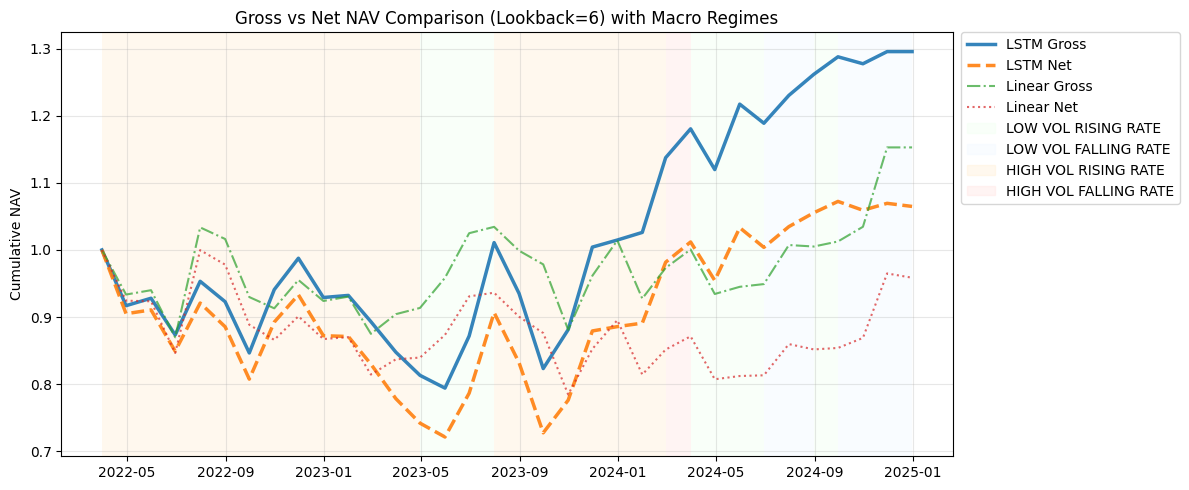


>> [Liquidity Diagnosis] Strategy Average Holdings Characteristics (L=6):


/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_65611/1952140029.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_65611/1952140029.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


        Avg_MktCap(B)    Avg_Volume  Avg_Spread(%)
Model                                             
LSTM      161063.5671  1.518255e+06         1.1539
Linear    278546.5414  2.457809e+06         1.0818

>> [Regime Perf] LSTM (L=6) Net Return Breakdown:
REGIME                       
HIGH_VOL_FALLING_RATE  N           2.0
                       AnnRet      NaN
                       Sharpe      NaN
HIGH_VOL_RISING_RATE   N            20
                       AnnRet    -3.8%
                       AnnVol    27.8%
                       Sharpe    -0.14
LOW_VOL_FALLING_RATE   N             5
                       AnnRet     3.9%
                       AnnVol     8.1%
                       Sharpe     0.48
LOW_VOL_RISING_RATE    N             7
                       AnnRet    17.0%
                       AnnVol    20.6%
                       Sharpe     0.82
dtype: object

============================== Lookback Window: 12 Months ==============================


/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_65611/1351569961.py:153: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("REGIME").apply(_stats)


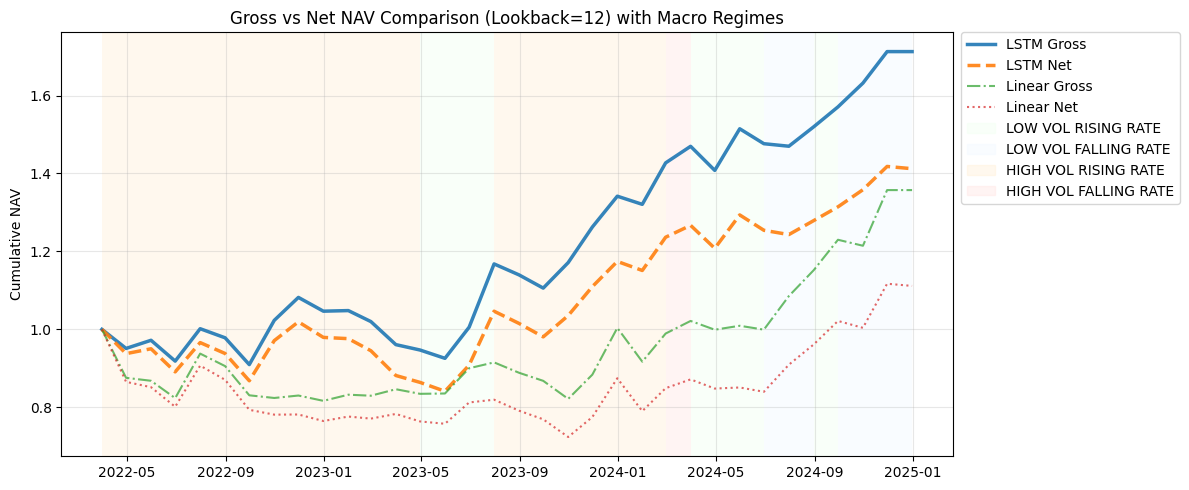


>> [Liquidity Diagnosis] Strategy Average Holdings Characteristics (L=12):


/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_65611/1952140029.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_65611/1952140029.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_65611/1351569961.py:153: DeprecationWarning: DataFrameGroupBy.apply operated 

        Avg_MktCap(B)    Avg_Volume  Avg_Spread(%)
Model                                             
LSTM      202804.5603  3.041499e+06         1.1504
Linear    244916.5121  2.689501e+06         1.1750

>> [Regime Perf] LSTM (L=12) Net Return Breakdown:
REGIME                       
HIGH_VOL_FALLING_RATE  N           2.0
                       AnnRet      NaN
                       Sharpe      NaN
HIGH_VOL_RISING_RATE   N            20
                       AnnRet     9.4%
                       AnnVol    22.7%
                       Sharpe     0.42
LOW_VOL_FALLING_RATE   N             5
                       AnnRet    16.9%
                       AnnVol    10.9%
                       Sharpe     1.56
LOW_VOL_RISING_RATE    N             7
                       AnnRet    20.9%
                       AnnVol    16.9%
                       Sharpe     1.23
dtype: object

============================== Lookback Window: 24 Months ==============================


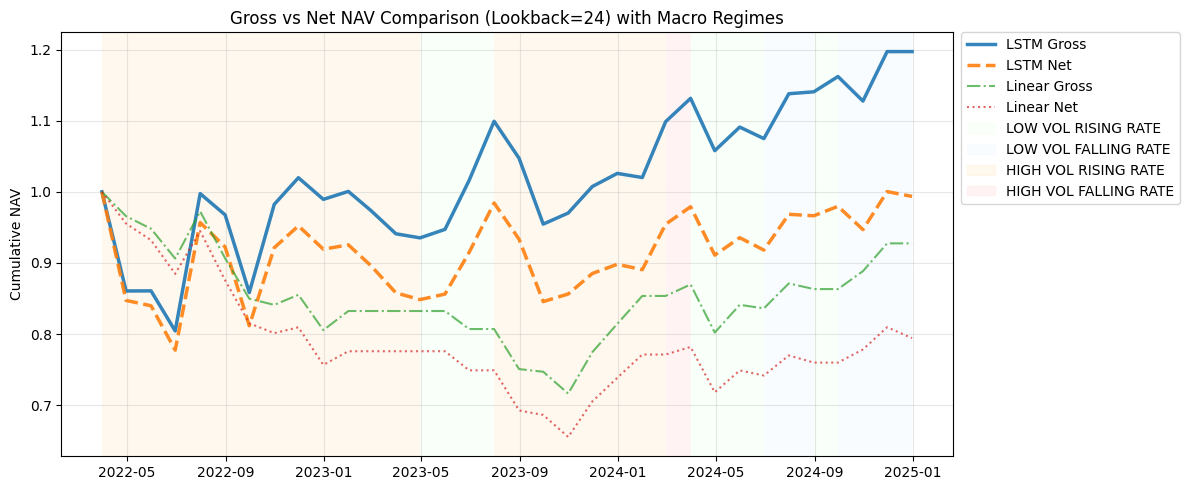


>> [Liquidity Diagnosis] Strategy Average Holdings Characteristics (L=24):


/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_65611/1952140029.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


        Avg_MktCap(B)    Avg_Volume  Avg_Spread(%)
Model                                             
LSTM      336626.7258  2.822900e+06         1.0985
Linear    185413.2179  1.469577e+06         1.1393

>> [Regime Perf] LSTM (L=24) Net Return Breakdown:
REGIME                       
HIGH_VOL_FALLING_RATE  N           2.0
                       AnnRet      NaN
                       Sharpe      NaN
HIGH_VOL_RISING_RATE   N            20
                       AnnRet    -6.5%
                       AnnVol    29.8%
                       Sharpe    -0.22
LOW_VOL_FALLING_RATE   N             5
                       AnnRet    19.0%
                       AnnVol    14.3%
                       Sharpe     1.33
LOW_VOL_RISING_RATE    N             7
                       AnnRet     8.5%
                       AnnVol    14.7%
                       Sharpe     0.58
dtype: object


/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_65611/1952140029.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
/var/folders/44/1ps5l4vs4mj07yfyyfncjkcr0000gn/T/ipykernel_65611/1351569961.py:153: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("REGIME").apply(_stats)


In [28]:
import matplotlib.pyplot as plt

# 1. Prepare macro regime data
macro = build_regime_table(vix_m, rate_m)
regime_series = macro.set_index("DATE")["REGIME_COMBO"]

# Set a unified evaluation start date (aligned with validation end date)
EVAL_START = "2022-01-31"

# Target universe for liquidity diagnostics (use the full panel to avoid missing info)
target_panel = all_df

# 2. Collect results for all strategies
all_results = {}

# --- A) Collect LSTM results ---
print(f"Starting LSTM Backtest (Start Date: {EVAL_START})...")
for r in results_lstm:
    L = r["lookback"]
    mdl = r["model"]

    print(f"  Processing LSTM L={L}...")

    # Run rolling backtest
    port_df, ret_df, nav = roll_forward_backtest(
        panel_df=all_df,           # Use the full panel so the model can access history
        model=mdl,
        seq_len=L,                 # Important: seq_len must equal the lookback L
        gap=1,
        top_n=100,
        ret_col="Y_FWD_1M",
        use_mcap=True,
        score_thresh=0.0,
        eval_start_date=EVAL_START # Important: restrict backtest to the test period only
    )

    # Compute net NAV after Corwin–Schultz cost adjustment
    ret_adj, nav_net = apply_cs_cost_adjustment(
        port_df=port_df, ret_df=ret_df,
        cs_monthly_spread=cs_monthly_spread, top_n=100, k=0.5
    )

    all_results[f"LSTM_L{L}"] = {
        "nav_gross": nav,
        "nav_net": nav_net,
        "ret_gross": ret_df["PORT_RET"],
        "ret_net": ret_adj["PORT_RET_NET"],
        "port_df": port_df
    }

# --- B) Collect Linear benchmark results ---
print(f"Starting Linear Backtest (Start Date: {EVAL_START})...")
for r in results_lin:
    L = r["lookback"]
    lin_model = r["model"]
    if lin_model is None: continue

    print(f"  Processing Linear L={L}...")

    
    port_df, ret_df, nav = roll_forward_backtest_linear(
        panel_df=all_df,
        lin_model=lin_model,
        seq_len=L,               # Linear model also needs sequences of length L (flattened)
        gap=1,
        top_n=100,
        ret_col="Y_FWD_1M",
        use_mcap=True,      # Use value-weighted portfolios
        score_thresh=0.0,
        use_last_only=False,
        eval_start_date=EVAL_START 
    )

    ret_adj, nav_net = apply_cs_cost_adjustment(
        port_df=port_df, ret_df=ret_df,
        cs_monthly_spread=cs_monthly_spread, top_n=100, k=0.5
    )

    all_results[f"Linear_L{L}"] = {
        "nav_gross": nav,
        "nav_net": nav_net,
        "ret_gross": ret_df["PORT_RET"],
        "ret_net": ret_adj["PORT_RET_NET"],
        "port_df": port_df
    }

# 3. Loop over lookback windows: plotting -> liquidity -> regime stats
unique_lookbacks = sorted(list(set(r["lookback"] for r in results_lstm)))

for L in unique_lookbacks:
    key_lstm = f"LSTM_L{L}"
    key_lin = f"Linear_L{L}"

    print(f"\n{'='*30} Lookback Window: {L} Months {'='*30}")

    # ---------------------------
    # Part 1: Plot NAV (Gross & Net combined)
    # ---------------------------
    navs_combined = {}

    # 1. LSTM curves
    if key_lstm in all_results:
        navs_combined["LSTM Gross"] = all_results[key_lstm]["nav_gross"]
        navs_combined["LSTM Net"]   = all_results[key_lstm]["nav_net"]

    # 2. Linear benchmark curves
    if key_lin in all_results:
        navs_combined["Linear Gross"] = all_results[key_lin]["nav_gross"]
        navs_combined["Linear Net"]   = all_results[key_lin]["nav_net"]

    # 3. Plot everything on the same figure with macro regime shading
    if navs_combined:
        plot_combined_nav_regime(
            navs_combined,
            regime_series,
            title=f"Gross vs Net NAV Comparison (Lookback={L}) with Macro Regimes"
        )

    # ---------------------------
    # Part 2: Liquidity diagnostics
    # ---------------------------
    print(f"\n>> [Liquidity Diagnosis] Strategy Average Holdings Characteristics (L={L}):")

    liq_summary = []

    # 2.1 LSTM liquidity profile
    if key_lstm in all_results:
        _, stats = analyze_topset_liquidity(
            all_results[key_lstm]["port_df"], target_panel, cs_monthly_spread, top_n=100
        )
        avg_stats = stats.mean(numeric_only=True)
        liq_summary.append({
            "Model": "LSTM",
            "Avg_MktCap(B)": avg_stats.get("AVG_MKT_CAP", 0) / 1e6,
            "Avg_Volume": avg_stats.get("AVG_VOL", 0),
            "Avg_Spread(%)": avg_stats.get("AVG_CS_SPREAD", 0) * 100
        })

    # 2.2 Linear liquidity profile
    if key_lin in all_results:
        _, stats = analyze_topset_liquidity(
            all_results[key_lin]["port_df"], target_panel, cs_monthly_spread, top_n=100
        )
        avg_stats = stats.mean(numeric_only=True)
        liq_summary.append({
            "Model": "Linear",
            "Avg_MktCap(B)": avg_stats.get("AVG_MKT_CAP", 0) / 1e6,
            "Avg_Volume": avg_stats.get("AVG_VOL", 0),
            "Avg_Spread(%)": avg_stats.get("AVG_CS_SPREAD", 0) * 100
        })

    # Print liquidity comparison table
    if liq_summary:
        df_liq = pd.DataFrame(liq_summary).set_index("Model")
        print(df_liq.round(4))
    else:
        print("No liquidity data available.")

    # ---------------------------
    # Part 3: Regime-conditional performance (focus on LSTM Net)
    # ---------------------------
    if key_lstm in all_results:
        print(f"\n>> [Regime Perf] LSTM (L={L}) Net Return Breakdown:")
        print(summarize_combo_regime_perf(all_results[key_lstm]["ret_net"], regime_series))

In [32]:
# === 1. Select the best-performing model and lookback window (based on Sharpe ratio) ===

perf_rows = []

# Iterate over all strategies (both LSTM and Linear)
for key, info in all_results.items():

    nav_net = info["nav_net"]
    nav_gross = info["nav_gross"]

    # Skip strategies with no NAV data
    if nav_net is None or len(nav_net) == 0:
        continue

    # Compute performance metrics
    ann_ret_gross = annualized_return(nav_gross) # Gross Annualized Return
    ann_ret_net   = annualized_return(nav_net)   # Net Annualized Return
    ann_sharpe    = annualized_sharpe(nav_net)   # Net Sharpe
    sortino       = sortino_ratio(nav_net)       # Net Sortino
    mdd           = max_drawdown(nav_net)        # Net Max Drawdown

    # Extract lookback length and model type from key
    if "LSTM" in key:
        model_type = "LSTM"
        lookback = int(key.split("LSTM_L")[1])
    elif "Linear" in key:
        model_type = "Linear"
        lookback = int(key.split("Linear_L")[1])

    perf_rows.append({
        "key": key,
        "ann_gross": ann_ret_gross, # Added Gross Return
        "ann_net": ann_ret_net,     # Renamed for clarity
        "sharpe": ann_sharpe,
        "sortino": sortino,
        "maxdd": mdd
    })

# Convert to DataFrame and sort by Sharpe ratio
perf_df = pd.DataFrame(perf_rows).sort_values("sharpe", ascending=False)

# Display the dataframe with formatted columns for better readability
# (Optional formatting can be applied here if needed, but raw DF is fine)
display(perf_df)

# Select the best model configuration based on Sharpe ratio
BEST_KEY = perf_df.iloc[0]["key"]

print(f"Use {BEST_KEY} for interpretability — strategy Sharpe best.")

,key,ann_gross,ann_net,sharpe,sortino,maxdd
1,LSTM_L12,0.215741,0.133506,0.732126,1.028885,-0.174811
4,Linear_L12,0.117309,0.039110,0.281713,0.339129,-0.276257
0,LSTM_L6,0.098561,0.023071,0.210267,0.234275,-0.278715
2,LSTM_L24,0.067523,-0.002341,0.107883,0.123380,-0.222587
3,Linear_L6,0.052971,-0.015236,0.031675,0.032737,-0.215422
5,Linear_L24,-0.026949,-0.080241,-0.505429,-0.430673,-0.344773


Use LSTM_L12for interpretability — strategy Sharpe best.


## Interpretability

In [30]:
# === 1. Select the best-performing LSTM lookback window (based on Sharpe ratio)===

perf_rows = []

for key, info in all_results.items():
    if not key.startswith("LSTM_L"):
        continue
    
    nav_net = info["nav_net"]
    
    if nav_net is None or len(nav_net) == 0:
        continue
    
    ann_ret    = annualized_return(nav_net)
    ann_sharpe = annualized_sharpe(nav_net)
    sortino    = sortino_ratio(nav_net)
    mdd        = max_drawdown(nav_net)
    
    lookback = int(key.split("LSTM_L")[1])
    
    perf_rows.append({
        "key": key,
        "lookback": lookback,
        "ann_ret": ann_ret,
        "sharpe": ann_sharpe,
        "sortino": sortino,
        "maxdd": mdd
    })

perf_lstm_df = pd.DataFrame(perf_rows).sort_values("sharpe", ascending=False)
display(perf_lstm_df)

BEST_KEY = perf_lstm_df.iloc[0]["key"]
BEST_L   = int(perf_lstm_df.iloc[0]["lookback"])

print(f"Use {BEST_KEY} (L={BEST_L}) for interpretability — strategy Sharpe best.")

,key,lookback,ann_ret,sharpe,sortino,maxdd
1,LSTM_L12,12,0.133506,0.732126,1.028885,-0.174811
0,LSTM_L6,6,0.023071,0.210267,0.234275,-0.278715
2,LSTM_L24,24,-0.002341,0.107883,0.123380,-0.222587


Use LSTM_L12 (L=12) for interpretability — strategy Sharpe best.


,LSTM_importance,Linear_importance
RET_Z,0.223142,0.064571
Y_SHORT_Z,0.205406,0.272184
MOM_3M_Z,0.138258,0.015091
DLOG_P_Z,0.127067,0.060889
VIX_Z,0.084550,0.496509
DLOG_V_Z,0.077269,0.015275
CS_SPREAD_Z,0.056714,0.019368
VOL_6M_Z,0.046721,0.015096
MOM_12M_Z,0.040873,0.041017


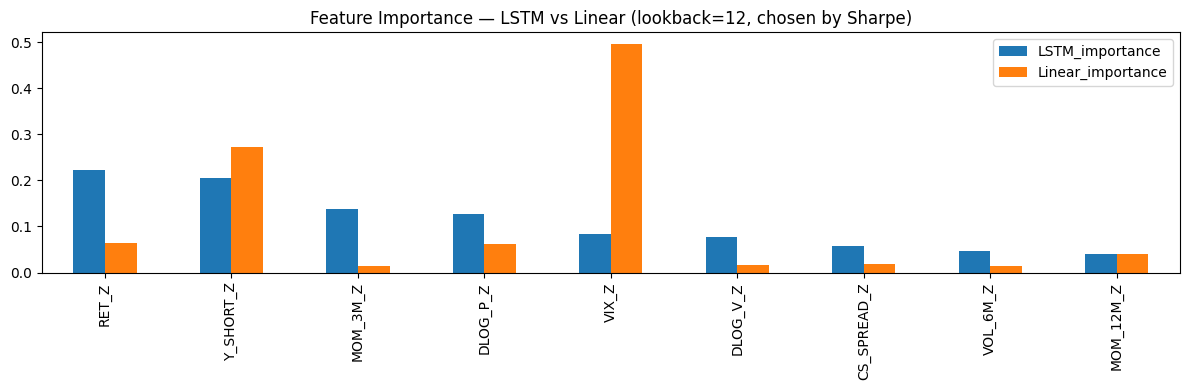

In [33]:
# === 2. Interpretability for best LSTM  ===

# Retrieve the best LSTM / Linear models
best_lstm_res = [r for r in results_lstm if r["lookback"] == BEST_L][0]
best_lin_res  = [r for r in results_lin  if r["lookback"] == BEST_L][0]

lstm_model = best_lstm_res["model"]
lin_model  = best_lin_res["model"]

# Rebuild test sequences X_te with the same lookback / splits as in training
(_, _), (_, _), (X_te, y_te, L_te, ID_te, DT_te) = make_splits_and_sequences(
    all_df,
    lookback=BEST_L,
    dt_train_end="2018-12-31",
    dt_valid_end="2022-01-31",
)

# === Gradient × Input attribution ===
def get_lstm_importance(model, X_list, max_samples=5000):
    model.eval()
    scores = []

    n=len(X_list)
    k = min(n, max_samples)

    idx = np.random.choice(n, size=k, replace=False)

    for i in idx:
        x_np = X_list[i]
        x = torch.from_numpy(x_np).float().unsqueeze(0)   
        lens = torch.tensor([x.size(1)], dtype=torch.long)
        x.requires_grad_(True)
        model.zero_grad()

        y_hat = model(x, lens)   # forward
        y_hat.backward()

        grad = x.grad.detach().numpy()[0]
        val  = x.detach().numpy()[0]

        scores.append(np.abs(grad[-1] * val[-1]))

    scores = np.stack(scores)
    imp = scores.mean(axis=0)
    imp = imp / imp.sum()
    return imp

# LSTM importance
imp_lstm = get_lstm_importance(lstm_model, X_te, max_samples=5000)
series_lstm = pd.Series(imp_lstm, index=FEATURES, name="LSTM_importance")

# Linear importance
coef = lin_model.coef_.reshape(BEST_L, len(FEATURES))
imp_lin = np.mean(np.abs(coef), axis=0)
imp_lin = imp_lin / imp_lin.sum()
series_lin = pd.Series(imp_lin, index=FEATURES, name="Linear_importance")

# Combine and sort by LSTM importance
df_imp = pd.concat([series_lstm, series_lin], axis=1).sort_values("LSTM_importance", ascending=False)
display(df_imp)

# bar chart
df_imp.plot(kind="bar", figsize=(12,4))
plt.title(f"Feature Importance — LSTM vs Linear (lookback={BEST_L}, chosen by Sharpe)")
plt.tight_layout()
plt.show()

### Interpretability of the Sharpe-Optimal LSTM Model (Lookback = 12, Market-cap-Weighted Portfolio)

Under market-cap-weighted portfolio construction, the LSTM model with a 12-month lookback (LSTM_L12) achieves the highest Sharpe ratio among the evaluated models. This makes LSTM_L12 the benchmark model for interpretability under the market-cap-weighted setting.

---

### 1. What the LSTM learns under market-cap-weighted returns

Unlike the equal-weighted case—where liquidity and momentum dominate—the market-cap-weighted LSTM places greater emphasis on **macro-linked and systematic-risk variables**, especially:

- **RET_Z** – single-period return  
  Still the strongest predictor under market-cap-weighting, indicating that large-cap stocks retain meaningful short-term return continuation.

- **Y_SHORT_Z** – short-rate / macro sensitivity  
  Value-weighted returns are more exposed to macroeconomic conditions. The LSTM assigns substantial importance to short-rate movements, which aligns with the higher macro beta of large-cap stocks.

- **MOM_3M_Z** – short-horizon momentum  
  This signal remains influential, though weaker than in equal-weight portfolios. It reflects trading-pressure continuation in large, liquid names.

- **DLOG_P_Z** – price-trend shocks  
  The LSTM learns that price-change shocks still contain predictive information for large-caps, especially during volatile markets or regime transitions.

- **VIX_Z** – volatility-regime indicator  
  Assigned moderate importance by the LSTM. Value-weighted portfolios remain sensitive to systematic volatility; the LSTM captures this but relies less heavily on it than the Linear baseline.

Lower-importance features include DLOG_V_Z, CS_SPREAD_Z, MOM_12M_Z, and VOL_6M_Z, indicating that microstructure noise and medium-term cycles play only secondary roles in large-cap universes.

**Overall, the LSTM integrates short-term return continuation, macro sensitivity, and liquidity-linked price dynamics**, mapping well to the characteristics of market-cap-weighted stock behavior.

---

### 2. Comparison with the Linear baseline

The Linear Ridge model collapses to a nearly two-factor structure:

- **Y_SHORT_Z** and **VIX_Z** dominate almost the entire coefficient mass  
- All other features have negligible contributions

This is expected:

- Large-cap returns exhibit strong exposure to systematic factors (rates & volatility)  
- Linear models cannot capture nonlinear interactions among short-term return shocks, liquidity flows, and macro variables  
- As a result, the Linear model fails to extract the richer predictive structure that the LSTM learns

**This difference in importance dispersion explains why the LSTM strategy produces a materially better Sharpe ratio than the Linear baseline.**

---

### 3. Economic interpretation under market-cap-weighted returns

The interpretability results show that the LSTM captures the economic drivers most relevant to capital-concentrated portfolios:

- **Short-term return continuation (RET_Z, MOM_3M_Z)**  
- **Macro sensitivity and yield-curve information (Y_SHORT_Z)**  
- **Systematic volatility exposure (VIX_Z)**  
- **Price-trend effects and liquidity-linked dynamics (DLOG_P_Z)**

These drivers align with the empirical behavior of large-cap equities, where returns are shaped more by **market regimes, macro signals, and short-term trading pressure**, and less by microstructure noise.

The improved Sharpe of LSTM_L12 therefore stems from its ability to combine **macro awareness, short-term continuation, and nonlinear price dynamics** into a cohesive predictive structure well-suited for market-cap-weighted portfolios.
